In [31]:
import os
from pathlib import Path

import pandas as pd
import polars as pl
from matplotlib import pyplot as plt
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from torch import argmax, concat, set_float32_matmul_precision, stack
from torch.utils.data import DataLoader

from mirror.dataloaders.loader import DataModule
from mirror.encoders import TableEncoder, YXDataset, YZDataset, ZDataset
from mirror.encoders.maps import rename
from mirror.models.cvae import CVAE
from mirror.models.cvae_components import (
    CVAEDecoderBlock,
    CVAEEncoderBlock,
    LabelsEncoderBlock,
)

In [32]:
LOGDIR = Path("demo_logs")

In [33]:
census = pl.read_csv("data/census.csv")
census = census.rename(rename)

# drop resident_id_m column
census = census.drop("pid")
print(len(census))

uniques = census.unique()
p = len(uniques) / len(census)
print(f"Probability of unique person = {p:.3}")

census.describe()

604351
Probability of unique person = 0.616


statistic,social,country_of_birth,employment_status,ethnicity,health,household_type,hours_worked,full_time_student,industry,inner/outer_london,marital_status,occupaion,region,religion,residence_type,age_group,sex,residency_type
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,str,f64,f64,f64,f64,f64
"""count""",604351.0,604351.0,604351.0,604351.0,604351.0,604351.0,604351.0,604351.0,604351.0,"""604351""",604351.0,604351.0,"""604351""",604351.0,604351.0,604351.0,604351.0,604351.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0
"""mean""",0.178228,1.063016,1.033194,3.497759,1.647728,2.218036,-3.070486,1.264133,2.121696,null,0.153633,1.086539,null,2.323451,1.018094,4.013229,1.489475,1.016006
"""std""",4.390827,1.048737,4.964835,1.565592,1.379937,1.718835,5.364332,2.233842,6.579392,null,4.008883,6.134046,null,2.434336,0.133291,2.128897,0.49989,0.142094
"""min""",-8.0,-8.0,-8.0,-8.0,-8.0,-8.0,-8.0,-8.0,-8.0,"""-8""",-8.0,-8.0,"""E12000001""",-8.0,1.0,1.0,1.0,1.0
"""25%""",1.0,1.0,1.0,4.0,1.0,2.0,-8.0,1.0,-8.0,null,1.0,-8.0,null,1.0,1.0,2.0,1.0,1.0
"""50%""",2.0,1.0,1.0,4.0,2.0,2.0,-8.0,2.0,5.0,null,1.0,3.0,null,2.0,1.0,4.0,1.0,1.0
"""75%""",3.0,1.0,5.0,4.0,2.0,3.0,3.0,2.0,8.0,null,2.0,6.0,null,2.0,1.0,6.0,2.0,1.0
"""max""",4.0,2.0,9.0,5.0,5.0,5.0,4.0,2.0,9.0,"""E13000002""",5.0,9.0,"""W92000004""",9.0,2.0,7.0,2.0,3.0


In [34]:
census.head()

social,country_of_birth,employment_status,ethnicity,health,household_type,hours_worked,full_time_student,industry,inner/outer_london,marital_status,occupaion,region,religion,residence_type,age_group,sex,residency_type
i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,str,i64,i64,i64,i64,i64
4,1,1,4,1,4,4,2,4,"""-8""",1,5,"""E12000003""",2,1,4,2,1
-8,1,5,4,2,1,-8,2,7,"""-8""",1,2,"""E12000005""",2,1,7,2,1
-8,2,5,4,2,1,-8,2,7,"""-8""",1,3,"""E12000002""",2,1,7,2,1
-8,1,5,4,3,2,-8,2,8,"""-8""",2,8,"""E12000006""",2,1,7,1,1
4,1,8,4,2,1,-8,2,9,"""-8""",1,9,"""E12000002""",1,1,2,2,1


In [35]:
# Define controls aka labels aka Y, that will be used to condition generation
controls = ["sex", "age_group", "region"]
census_controls = census[controls]
target_census = census.drop(controls)

controls_encoder = TableEncoder(census_controls, verbose=True)
y_dataset = controls_encoder.encode(data=census_controls)
controls_encoder.names()

CategoricalTokeniser: size: 2, categories: {1: 0, 2: 1}, dtype: Int64
CategoricalTokeniser: size: 7, categories: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}, dtype: Int64
CategoricalTokeniser: size: 10, categories: {'E12000001': 0, 'E12000002': 1, 'E12000003': 2, 'E12000004': 3, 'E12000005': 4, 'E12000006': 5, 'E12000007': 6, 'E12000008': 7, 'E12000009': 8, 'W92000004': 9}, dtype: String
<mirror.encoders.table_encoder.TableEncoder object at 0x000001E8F5476960> encoded -> <mirror.encoders.table_encoder.CensusDataset object at 0x000001E8F4113200>: torch.Size([604351, 3])


['sex', 'age_group', 'region']

In [36]:
# Define census aka X, that will be generated
census_encoder = TableEncoder(target_census, verbose=True)
x_dataset = census_encoder.encode(data=target_census)
census_encoder.names()

CategoricalTokeniser: size: 5, categories: {-8: 0, 1: 1, 2: 2, 3: 3, 4: 4}, dtype: Int64
CategoricalTokeniser: size: 3, categories: {-8: 0, 1: 1, 2: 2}, dtype: Int64
CategoricalTokeniser: size: 10, categories: {-8: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}, dtype: Int64
CategoricalTokeniser: size: 6, categories: {-8: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}, dtype: Int64
CategoricalTokeniser: size: 6, categories: {-8: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}, dtype: Int64
CategoricalTokeniser: size: 6, categories: {-8: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}, dtype: Int64
CategoricalTokeniser: size: 5, categories: {-8: 0, 1: 1, 2: 2, 3: 3, 4: 4}, dtype: Int64
CategoricalTokeniser: size: 3, categories: {-8: 0, 1: 1, 2: 2}, dtype: Int64
CategoricalTokeniser: size: 10, categories: {-8: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}, dtype: Int64
CategoricalTokeniser: size: 3, categories: {'-8': 0, 'E13000001': 1, 'E13000002': 2}, dtype: String
CategoricalTokeniser: size: 6, categories: 

['social',
 'country_of_birth',
 'employment_status',
 'ethnicity',
 'health',
 'household_type',
 'hours_worked',
 'full_time_student',
 'industry',
 'inner/outer_london',
 'marital_status',
 'occupaion',
 'religion',
 'residence_type',
 'residency_type']

In [37]:
# combine into dataset object
yx_dataset = YXDataset(x_dataset, y_dataset)
dataloader = DataModule(
    dataset=yx_dataset,
    val_split=0.1,
    test_split=0.1,
    train_batch_size=512,
    val_batch_size=512,
    test_batch_size=512,
    num_workers=4,
    pin_memory=False,
)

In [38]:
latent = 12

# encoder block to embed labels into vec with hidden size
labels_encoder_block = LabelsEncoderBlock(
    encoder_types=controls_encoder.types(),
    encoder_sizes=controls_encoder.sizes(),
    depth=2,
    hidden_size=32,
)

# encoder and decoder block to process census data
encoder = CVAEEncoderBlock(
    encoder_types=census_encoder.types(),
    encoder_sizes=census_encoder.sizes(),
    depth=2,
    hidden_size=32,
    latent_size=latent,
)
decoder = CVAEDecoderBlock(
    encoder_types=census_encoder.types(),
    encoder_sizes=census_encoder.sizes(),
    depth=2,
    hidden_size=32,
    latent_size=latent,
)

# CVAE model
cvae = CVAE(
    embedding_names=census_encoder.names(),
    embedding_types=census_encoder.types(),
    embedding_weights=census_encoder.weights(),
    labels_encoder_block=labels_encoder_block,
    encoder_block=encoder,
    decoder_block=decoder,
    beta=0.1,
    lr=0.001,
)

In [39]:
set_float32_matmul_precision("medium")

LOGDIR.mkdir(parents=True, exist_ok=True)
log_dir = str(Path(LOGDIR))

logger = WandbLogger(project="nomis_demo", dir=log_dir)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, mode="min"),
    ModelCheckpoint(
        monitor="val_loss",
        save_top_k=1,
        mode="min",
        dirpath=Path(log_dir, "checkpoints"),
        save_weights_only=False,
    ),
]
trainer = Trainer(
    min_epochs=1,
    max_epochs=10,
    callbacks=callbacks,
    logger=logger,
    check_val_every_n_epoch=1,
)
trainer.fit(model=cvae, train_dataloaders=dataloader)
# trainer.validate(model=cvae, dataloaders=dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\fred\Projects\mirror\.venv\Lib\site-packages\pytorch_lightning\loggers\wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
c:\Users\fred\Projects\mirror\.venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:658: Checkpoint directory C:\Users\fred\Projects\mirror\demo_logs\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type               | Params | Mode 
--------------------------------------------------------------------
0 | labels_encoder_block | LabelsEncoderBlock | 2.7 K  | train
1 | encoder_block        | CVAEEncoderBlock   | 5.7 K  | train
2 | decoder_block        | CVAEDecoderBlock   | 4.4 K  | train
3 | criterion            | Modul

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [40]:
n = len(yx_dataset)
z_loader = ZDataset(n, latent_size=latent)
yz_loader = YZDataset(z_loader, y_dataset)
gen_loader = DataLoader(
    yz_loader, batch_size=512, num_workers=4, persistent_workers=True
)

ys, xs, zs = zip(*trainer.predict(dataloaders=gen_loader))
ys = concat(ys)
xs = concat([stack([argmax(x, dim=1) for x in xb], dim=-1) for xb in xs], dim=0)
zs = concat(zs)

c:\Users\fred\Projects\mirror\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:149: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at C:\Users\fred\Projects\mirror\demo_logs\checkpoints\epoch=0-step=945-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at C:\Users\fred\Projects\mirror\demo_logs\checkpoints\epoch=0-step=945-v1.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

In [41]:
controls_df = controls_encoder.decode(ys)
census_df = census_encoder.decode(xs).drop("pid")
df = pl.concat([controls_df, census_df], how="horizontal")
df.head()

pid,sex,age_group,region,social,country_of_birth,employment_status,ethnicity,health,household_type,hours_worked,full_time_student,industry,inner/outer_london,marital_status,occupaion,religion,residence_type,residency_type
i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64
0,2,4,"""E12000003""",1,2,2,4,2,5,4,2,4,"""-8""",1,5,1,1,1
1,2,7,"""E12000005""",-8,1,5,4,4,1,-8,2,1,"""-8""",5,8,2,2,1
2,2,7,"""E12000002""",-8,1,5,4,5,1,-8,2,1,"""-8""",5,8,2,2,1
3,1,7,"""E12000006""",-8,1,5,4,4,1,-8,2,8,"""-8""",5,4,2,2,1
4,2,2,"""E12000002""",2,-8,6,-8,-8,-8,1,1,5,"""-8""",1,9,-8,2,2


In [42]:
os.makedirs("tmp", exist_ok=True)
path = Path("tmp") / "demo_synthetic.csv"
print(f"Writing synthetic data to {path}")
df.write_csv(path)

Writing synthetic data to tmp\demo_synthetic.csv


In [43]:
synthetic = pl.read_csv(path).drop(["pid"])
synthetic.head()

sex,age_group,region,social,country_of_birth,employment_status,ethnicity,health,household_type,hours_worked,full_time_student,industry,inner/outer_london,marital_status,occupaion,religion,residence_type,residency_type
i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64
2,4,"""E12000003""",1,2,2,4,2,5,4,2,4,"""-8""",1,5,1,1,1
2,7,"""E12000005""",-8,1,5,4,4,1,-8,2,1,"""-8""",5,8,2,2,1
2,7,"""E12000002""",-8,1,5,4,5,1,-8,2,1,"""-8""",5,8,2,2,1
1,7,"""E12000006""",-8,1,5,4,4,1,-8,2,8,"""-8""",5,4,2,2,1
2,2,"""E12000002""",2,-8,6,-8,-8,-8,1,1,5,"""-8""",1,9,-8,2,2


In [44]:
from mirror.eval import density

census.head()

social,country_of_birth,employment_status,ethnicity,health,household_type,hours_worked,full_time_student,industry,inner/outer_london,marital_status,occupaion,region,religion,residence_type,age_group,sex,residency_type
i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,str,i64,i64,i64,i64,i64
4,1,1,4,1,4,4,2,4,"""-8""",1,5,"""E12000003""",2,1,4,2,1
-8,1,5,4,2,1,-8,2,7,"""-8""",1,2,"""E12000005""",2,1,7,2,1
-8,2,5,4,2,1,-8,2,7,"""-8""",1,3,"""E12000002""",2,1,7,2,1
-8,1,5,4,3,2,-8,2,8,"""-8""",2,8,"""E12000006""",2,1,7,1,1
4,1,8,4,2,1,-8,2,9,"""-8""",1,9,"""E12000002""",1,1,2,2,1


In [46]:
density.frequencies(census, ["sex"], alias="target")

target,index
u32,str
295815,"""2"""
308536,"""1"""


Order 1:


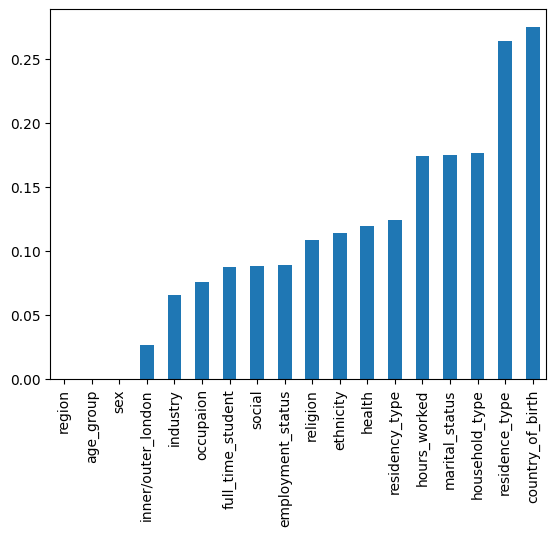

In [ ]:
results = {}
for order in range(1, 2):
    print(f"Order {order}:")
    maes = {}
    for name, target, synthetic in compute_joint_frequencies(
        census, df, order=order
    ):
        join = join_probs(target, synthetic)
        maes[name] = calc_mae(join)
    results[order] = maes

    pd.Series(results[1]).sort_values().plot.bar()

calculating order 1
calculating order 2
Order 1: MAE mean = 0.4140


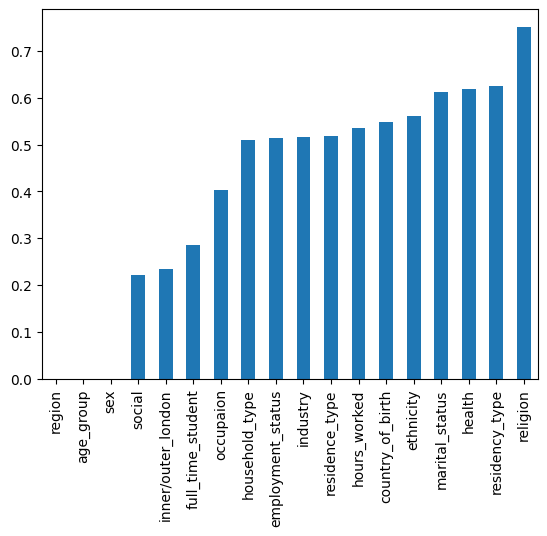

religion    0.750889
dtype: float64
Order 2: MAE mean = 0.7401


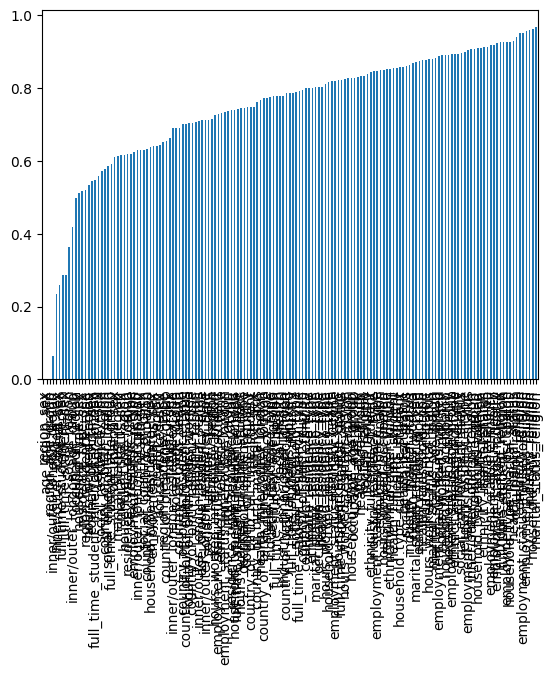

marital_status_religion    0.966282
dtype: float64


In [ ]:
results = {}
for order in range(1, 3):
    print(f"calculating order {order}")
    maes = {}
    for name, target, synthetic in compute_joint_frequencies(
        census, df, order=order
    ):
        join = join_probs(target, synthetic)
        maes[name] = calc_mnae(join)
    results[order] = maes

for order, res in results.items():
    print(f"Order {order}: MAE mean = {pd.Series(res).mean():.4f}")
    pd.Series(res).sort_values().plot.bar()
    plt.show()
    print(pd.Series(res).sort_values().tail(1))

In [ ]:
pd.Series(results[1]).sort_values().tail(1)

religion    0.750889
dtype: float64

In [ ]:
census["household_type"].value_counts().join(
    df["household_type"].value_counts(), on="household_type", how="outer"
)

C:\Users\fred\AppData\Local\Temp\ipykernel_18648\1197864847.py:1: DeprecationWarning: use of `how='outer'` should be replaced with `how='full'`.
(Deprecated in version 0.20.29)
  census["household_type"].value_counts().join(


household_type,count,household_type_right,count_right
i64,u32,i64,u32
1,76004,1,218075
4,82801,4,111272
2,320211,null,null
3,93538,3,150941
5,20508,5,65163
-8,11289,-8,58900


In [ ]:
df["household_type"].value_counts()

household_type,count
i64,u32
4,111272
3,150941
-8,58900
1,218075
5,65163
